In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from collections import Counter
import time
from torchvision import datasets, transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


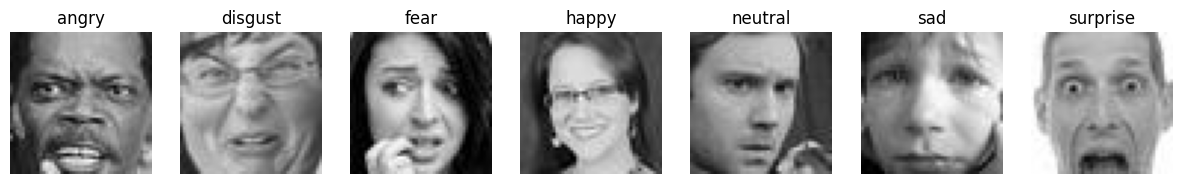

In [3]:
# transformasi (resize + tensor)
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])

# load dataset
train_data = datasets.ImageFolder(root="dataset/train", transform=transform)
val_dataset   = datasets.ImageFolder(root="dataset/val", transform=transform)
test_dataset  = datasets.ImageFolder(root="dataset/test", transform=transform)

# ambil class names
classes = train_data.classes
print("Classes:", classes)

# plot 1 gambar per kelas
fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))
for i, cls in enumerate(classes):
    # cari index pertama dari kelas tersebut
    idx = [j for j, (_, label) in enumerate(train_data.samples) if label == i][0]
    img, label = train_data[idx]
    
    axes[i].imshow(img.permute(1, 2, 0))  # ubah dari (C,H,W) ke (H,W,C)
    axes[i].set_title(classes[label])
    axes[i].axis("off")

plt.show()

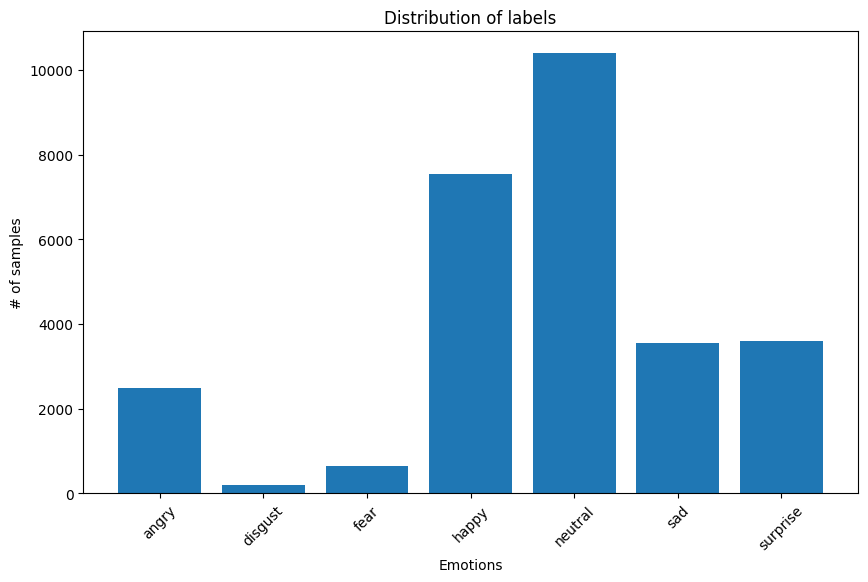

In [4]:
# Ambil semua label dari dataset
labels = [label for _, label in train_data]

# Hitung distribusi dengan Counter
label_count = Counter(labels)

# Ambil nama kelas
class_names = train_data.classes
num_classes = len(class_names)

# Urutkan jumlah sesuai urutan kelas
counts = [label_count[i] for i in range(num_classes)]

# Plot distribusi
plt.figure(figsize=(10,6))
plt.bar(class_names, counts)
plt.xlabel('Emotions')
plt.ylabel('# of samples')
plt.title('Distribution of labels')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Ambil semua label dari dataset
targets = [label for _, label in train_data]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts

# Bobot tiap sample
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader dengan sampler
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler)

In [6]:
def plot_distribution(dataset, loader=None, class_labels=None, title="Distribution"):
    """
    dataset     : ImageFolder dataset
    loader      : DataLoader (optional, kalau ingin cek distribusi setelah sampler)
    class_labels: list nama kelas
    title       : judul grafik
    """
    if loader is None:
        # Distribusi original dari dataset
        targets = [label for _, label in dataset]
        counts = Counter(targets)
        plt_title = f"{title} (Original Dataset)"
    else:
        # Distribusi setelah sampling (1 epoch penuh)
        sampled_labels = []
        for _, labels in loader:
            sampled_labels.extend(labels.numpy())
        counts = Counter(sampled_labels)
        plt_title = f"{title} (After Sampling)"
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.bar(class_labels, [counts[i] for i in range(len(class_labels))])
    plt.xlabel("Emotions")
    plt.ylabel("# of samples")
    plt.title(plt_title)
    plt.show()

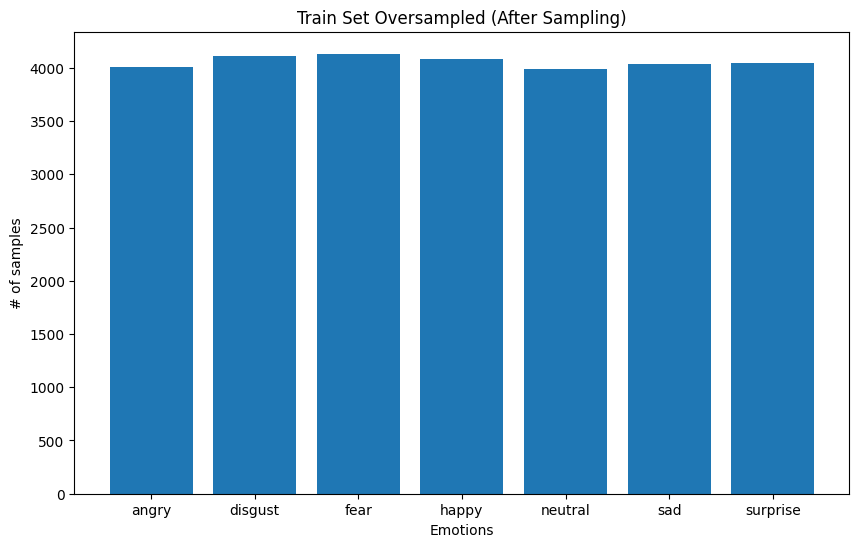

In [7]:
# Sesudah balancing (pakai sampler di DataLoader)
plot_distribution(train_data, loader=train_loader, class_labels=classes, title="Train Set Oversampled")

In [8]:
# Augmentasi untuk training
train_transform = T.Compose([
    T.Grayscale(num_output_channels=1),  # pastikan grayscale
    T.Resize((48, 48)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.85, 1.15), shear=10),
    T.RandomApply([
        T.ColorJitter(brightness=0.3, contrast=0.3)
    ], p=0.5),
    T.ToTensor(),
    T.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.0), value=0),
    T.Normalize((0.5,), (0.5,))
])

# Transformasi validasi & test (tanpa augmentasi, hanya normalisasi)
test_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder("dataset/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("dataset/val", transform=test_transform)
test_dataset  = datasets.ImageFolder("dataset/test", transform=test_transform)

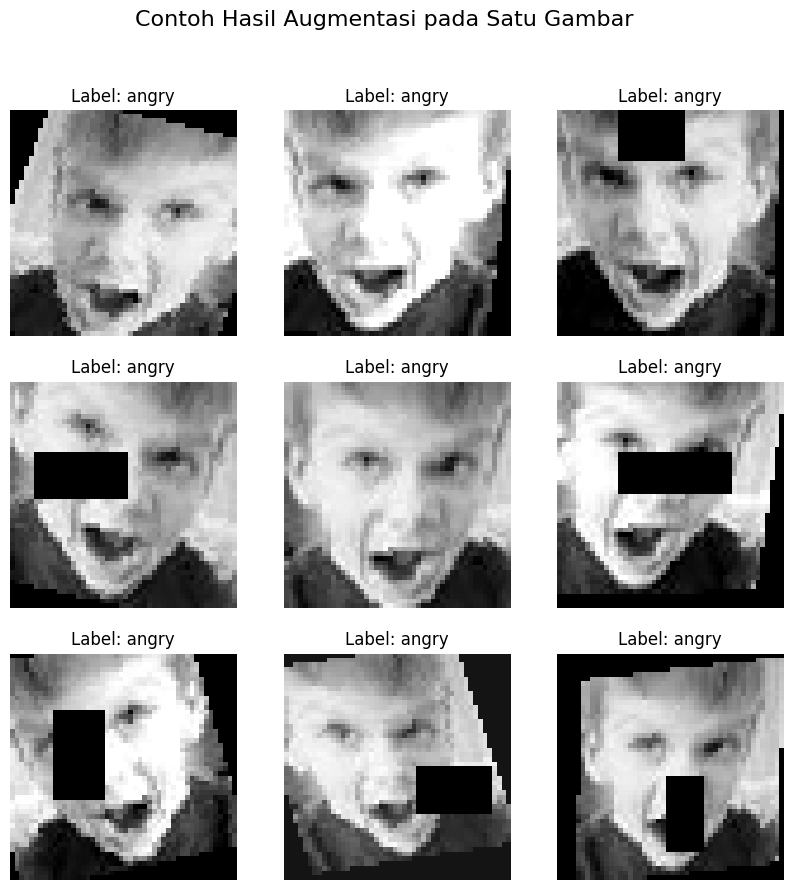

In [9]:
# Ambil dataset train yang sudah ada augmentasi
augmented_train_dataset = train_dataset  # dari ImageFolder + train_transform

plt.figure(figsize=(10, 10))

# Ambil 9 contoh augmentasi dari 1 gambar yang sama
img_idx = 7  # index gambar
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image, label = augmented_train_dataset[img_idx]  # augmentasi diterapkan setiap panggilan
    plt.imshow(augmented_image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title(f"Label: {augmented_train_dataset.classes[label]}")
    plt.axis("off")

plt.suptitle("Contoh Hasil Augmentasi pada Satu Gambar", fontsize=16)
plt.show()

In [10]:
# arsitektur model dengan blok residual dan blok SE

# CLass Blok SE
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Class Blok residual
class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualSEBlock, self).__init__()
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.se = SEBlock(out_channels)
        self.shortcut_path = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.main_path(x)
        out = self.se(out)
        shortcut = self.shortcut_path(x)
        return F.relu(out + shortcut)

# arsitektur dengan blok residual dan blok SE
class cnn_model(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=7):
        super(cnn_model, self).__init__()
        self.in_channels = 64

        self.stem = nn.Sequential(
            nn.Conv2d(1, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.stage1 = self._make_stage(64, num_blocks=3, stride=1)
        self.stage2 = self._make_stage(128, num_blocks=3, stride=2)
        self.stage3 = self._make_stage(256, num_blocks=3, stride=2)
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def _make_stage(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for s in strides:
            blocks.append(ResidualSEBlock(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.classifier(x)
        return x

In [11]:
model = cnn_model(num_classes=7, dropout_rate=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(32, 1, 48, 48))

Layer (type:depth-idx)                        Output Shape              Param #
cnn_model                                     [32, 7]                   --
├─Sequential: 1-1                             [32, 64, 24, 24]          --
│    └─Conv2d: 2-1                            [32, 64, 48, 48]          576
│    └─BatchNorm2d: 2-2                       [32, 64, 48, 48]          128
│    └─ReLU: 2-3                              [32, 64, 48, 48]          --
│    └─MaxPool2d: 2-4                         [32, 64, 24, 24]          --
├─Sequential: 1-2                             [32, 64, 24, 24]          --
│    └─ResidualSEBlock: 2-5                   [32, 64, 24, 24]          --
│    │    └─Sequential: 3-1                   [32, 64, 24, 24]          73,984
│    │    └─SEBlock: 3-2                      [32, 64, 24, 24]          512
│    │    └─Sequential: 3-3                   [32, 64, 24, 24]          --
│    └─ResidualSEBlock: 2-6                   [32, 64, 24, 24]          --
│    │    └─S

In [12]:
import optuna
from optuna.trial import TrialState

EPOCHS = 100
PATIENCE = 10
best_accuracy_overall = -1.0


def objective(trial):
    global best_accuracy_overall

    # --- Hyperparameter yang akan dioptimasi ---
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.4, 0.7)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])

    # --- Setup Model ---
    model = cnn_model(dropout_rate=dropout_rate, num_classes=len(train_dataset.classes)).to(device)

    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.8, 0.99)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)

    # --- Dataloader ---
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss().to(device)
    
    best_accuracy_in_trial = 0.0
    patience_counter = 0

    # --- Training Loop ---
    for epoch in range(EPOCHS):
        model.train()
        for img_batch, label_batch in train_dataloader:
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            optimizer.zero_grad()
            output = model(img_batch)
            loss = criterion(output, label_batch)
            loss.backward()
            optimizer.step()
        
        # --- Validation ---
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for img_batch, label_batch in val_dataloader:
                img_batch, label_batch = img_batch.to(device), label_batch.to(device)
                output = model(img_batch)
                _, predicted = torch.max(output.data, 1)
                total += label_batch.size(0)
                correct += (predicted == label_batch).sum().item()
        
        accuracy = correct / total
        
        # Simpan model terbaik secara global
        if accuracy > best_accuracy_overall:
            best_accuracy_overall = accuracy
            torch.save(model.state_dict(), "best_model_from_optuna.pth")
            print(f"--> New GLOBAL best model saved from Trial {trial.number} at epoch {epoch} with accuracy {accuracy:.4f}")
            
        # Early Stopping
        if accuracy > best_accuracy_in_trial:
            best_accuracy_in_trial = accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            break
            
        # Laporkan ke Optuna
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_accuracy_in_trial

d:\Mugni\VS Code\emotion-recognition\emotion-recognition\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Tentukan nama file database dan nama untuk study
db_file_name = "emotion_recognition.db"
storage_name = f"sqlite:///{db_file_name}"
study_name = "cnn_emotion_training_with_blok_residual_and_blokSE_7"

print(f"Menggunakan dan menyimpan study ke database: {db_file_name}")
print(f"Nama study: {study_name}")

# Buat atau muat study
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(),
    storage=storage_name,
    study_name=study_name,
    load_if_exists=True
)

# Jalankan optimisasi, sekarang TANPA callback
study.optimize(
    objective, 
    n_trials=20, 
    timeout=86400
)

print("\nProses optimisasi selesai.")

Menggunakan dan menyimpan study ke database: emotion_recognition.db
Nama study: cnn_emotion_training_with_blok_residual_and_blokSE_7


[I 2025-10-06 00:13:55,141] Using an existing study with name 'cnn_emotion_training_with_blok_residual_and_blokSE_7' instead of creating a new one.


--> New GLOBAL best model saved from Trial 1 at epoch 0 with accuracy 0.3765
--> New GLOBAL best model saved from Trial 1 at epoch 2 with accuracy 0.5639
--> New GLOBAL best model saved from Trial 1 at epoch 3 with accuracy 0.5957
--> New GLOBAL best model saved from Trial 1 at epoch 4 with accuracy 0.6297
--> New GLOBAL best model saved from Trial 1 at epoch 5 with accuracy 0.6621
--> New GLOBAL best model saved from Trial 1 at epoch 6 with accuracy 0.6671
--> New GLOBAL best model saved from Trial 1 at epoch 7 with accuracy 0.6888
--> New GLOBAL best model saved from Trial 1 at epoch 9 with accuracy 0.7138
--> New GLOBAL best model saved from Trial 1 at epoch 11 with accuracy 0.7144
--> New GLOBAL best model saved from Trial 1 at epoch 12 with accuracy 0.7279
--> New GLOBAL best model saved from Trial 1 at epoch 13 with accuracy 0.7451
--> New GLOBAL best model saved from Trial 1 at epoch 19 with accuracy 0.7530
--> New GLOBAL best model saved from Trial 1 at epoch 22 with accuracy 0

[I 2025-10-06 01:27:16,499] Trial 1 finished with value: 0.8117613956105796 and parameters: {'lr': 0.0012476082382180539, 'batch_size': 128, 'dropout_rate': 0.5312207973519679, 'weight_decay': 1.94830735624799e-05, 'optimizer': 'SGD', 'momentum': 0.8595460862817224}. Best is trial 1 with value: 0.8117613956105796.
[I 2025-10-06 02:05:44,025] Trial 2 finished with value: 0.6944288126055149 and parameters: {'lr': 0.008825037210455713, 'batch_size': 256, 'dropout_rate': 0.41428295752666405, 'weight_decay': 0.0007000833222377113, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.8117613956105796.


--> New GLOBAL best model saved from Trial 3 at epoch 24 with accuracy 0.8185
--> New GLOBAL best model saved from Trial 3 at epoch 33 with accuracy 0.8194
--> New GLOBAL best model saved from Trial 3 at epoch 38 with accuracy 0.8210
--> New GLOBAL best model saved from Trial 3 at epoch 43 with accuracy 0.8250
--> New GLOBAL best model saved from Trial 3 at epoch 47 with accuracy 0.8278


[I 2025-10-06 03:25:29,271] Trial 3 finished with value: 0.8277996623522791 and parameters: {'lr': 0.00018573381362381352, 'batch_size': 32, 'dropout_rate': 0.438771357174709, 'weight_decay': 0.0007675673190473736, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.8277996623522791.
[I 2025-10-06 04:19:55,862] Trial 4 finished with value: 0.7915025323579066 and parameters: {'lr': 0.0010906998357020498, 'batch_size': 256, 'dropout_rate': 0.6876642911977385, 'weight_decay': 0.00013547120094942988, 'optimizer': 'SGD', 'momentum': 0.9101651072391367}. Best is trial 3 with value: 0.8277996623522791.


--> New GLOBAL best model saved from Trial 5 at epoch 35 with accuracy 0.8281


[I 2025-10-06 05:18:41,948] Trial 5 finished with value: 0.8280810354530107 and parameters: {'lr': 0.0003164578329573675, 'batch_size': 32, 'dropout_rate': 0.4374901649885178, 'weight_decay': 2.3219112370552925e-05, 'optimizer': 'AdamW'}. Best is trial 5 with value: 0.8280810354530107.
[I 2025-10-06 05:19:27,139] Trial 6 pruned. 
[I 2025-10-06 05:20:16,120] Trial 7 pruned. 
[I 2025-10-06 05:26:25,995] Trial 8 pruned. 
[I 2025-10-06 06:10:28,925] Trial 9 finished with value: 0.8275182892515476 and parameters: {'lr': 0.0005929807172157115, 'batch_size': 64, 'dropout_rate': 0.49518108644258785, 'weight_decay': 1.001003932715938e-05, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.8280810354530107.
[I 2025-10-06 06:11:19,491] Trial 10 pruned. 


--> New GLOBAL best model saved from Trial 11 at epoch 42 with accuracy 0.8295
--> New GLOBAL best model saved from Trial 11 at epoch 44 with accuracy 0.8317


[I 2025-10-06 07:21:40,039] Trial 11 finished with value: 0.8317388857625211 and parameters: {'lr': 0.00012667012534561643, 'batch_size': 32, 'dropout_rate': 0.6138445624900789, 'weight_decay': 3.752755605448063e-05, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.8317388857625211.
[I 2025-10-06 07:30:28,569] Trial 12 pruned. 
[I 2025-10-06 07:31:45,455] Trial 13 pruned. 
[I 2025-10-06 07:49:29,459] Trial 14 pruned. 


--> New GLOBAL best model saved from Trial 15 at epoch 53 with accuracy 0.8351


[I 2025-10-06 08:57:32,685] Trial 15 finished with value: 0.8351153629713 and parameters: {'lr': 0.00024258968682884502, 'batch_size': 64, 'dropout_rate': 0.47533470775836617, 'weight_decay': 7.731076409113527e-05, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.8351153629713.
[I 2025-10-06 11:00:22,389] Trial 16 pruned. 
[I 2025-10-06 11:53:36,871] Trial 17 pruned. 
[I 2025-10-06 11:55:45,557] Trial 18 pruned. 
[I 2025-10-06 11:56:51,301] Trial 19 pruned. 
[I 2025-10-06 11:58:54,192] Trial 20 pruned. 



Proses optimisasi selesai.


In [13]:
import optuna

db_file_name = "emotion_recognition.db"
storage_name = f"sqlite:///{db_file_name}"

print(f"Membaca daftar study dari: {storage_name}\n")

try:
    all_studies = optuna.get_all_study_summaries(storage=storage_name)

    print(f"Ditemukan {len(all_studies)} study di dalam database:")
    
    if not all_studies:
        print("-> Database masih kosong atau tidak ditemukan study.")
    else:
        for i, summary in enumerate(all_studies):
            print(f"\n--- Study #{i+1} ---")
            print(f"  Nama Study     : '{summary.study_name}'")
            print(f"  Jumlah Trial   : {summary.n_trials}")
            
            if summary.best_trial:
                print(f"  Skor Terbaik   : {summary.best_trial.value:.4f}")
            else:
                print(f"  Skor Terbaik   : Belum ada trial yang selesai dengan sukses.")

except Exception as e:
    print(f"Terjadi error saat mengakses database: {e}")
    print("Pastikan nama file dan path sudah benar, dan tidak ada proses lain yang sedang mengunci file tersebut.")

Membaca daftar study dari: sqlite:///emotion_recognition.db

Ditemukan 7 study di dalam database:

--- Study #1 ---
  Nama Study     : 'cnn_emotion_training_with_blok_residual_and_blokSE'
  Jumlah Trial   : 20
  Skor Terbaik   : 0.8334

--- Study #2 ---
  Nama Study     : 'cnn_emotion_training_with_blok_residual_and_blokSE_2'
  Jumlah Trial   : 21
  Skor Terbaik   : 0.7985

--- Study #3 ---
  Nama Study     : 'cnn_emotion_training_with_blok_residual_and_blokSE_3'
  Jumlah Trial   : 5
  Skor Terbaik   : 0.8323

--- Study #4 ---
  Nama Study     : 'cnn_emotion_training_with_blok_residual_and_blokSE_4'
  Jumlah Trial   : 20
  Skor Terbaik   : 0.8385

--- Study #5 ---
  Nama Study     : 'cnn_emotion_training_with_blok_residual_and_blokSE_5'
  Jumlah Trial   : 3
  Skor Terbaik   : 0.8292

--- Study #6 ---
  Nama Study     : 'cnn_emotion_training_with_blok_residual_and_blokSE_6'
  Jumlah Trial   : 5
  Skor Terbaik   : 0.8044

--- Study #7 ---
  Nama Study     : 'cnn_emotion_training_with_blo

In [14]:
import optuna

db_file_name = "emotion_recognition.db"
storage_name = f"sqlite:///{db_file_name}"
study_name = "cnn_emotion_training_with_blok_residual_and_blokSE_7"

print(f"Memuat hasil study '{study_name}' dari file '{db_file_name}'")
loaded_study = optuna.load_study(
    study_name=study_name, 
    storage=storage_name
)

print("\n--- Hasil Akhir Study ---")

# =================================================================
# Lihat hasilnya
# =================================================================
pruned_trials = loaded_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = loaded_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(loaded_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\nBest trial:")
trial = loaded_study.best_trial

print("  Value (Max Validation Accuracy): ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# =================================================================
# UNTUK MELIHAT EPOCH OPTIMALNYA
# =================================================================
print("\n--- Analisis Tambahan untuk Trial Terbaik ---")

# Dapatkan dictionary {epoch: accuracy} dari trial terbaik
intermediate_values = trial.intermediate_values
# Cari epoch dengan accuracy tertinggi
optimal_epoch = max(intermediate_values, key=intermediate_values.get) if intermediate_values else 'N/A'
total_epochs_run = len(intermediate_values)

print(f"  - Performa terbaik dicapai pada epoch ke: {optimal_epoch}")
print(f"  - Trial ini berjalan selama {total_epochs_run} epoch dari maksimal {EPOCHS} epoch.")

Memuat hasil study 'cnn_emotion_training_with_blok_residual_and_blokSE_7' dari file 'emotion_recognition.db'

--- Hasil Akhir Study ---
Study statistics: 
  Number of finished trials:  21
  Number of pruned trials:  12
  Number of complete trials:  8

Best trial:
  Value (Max Validation Accuracy):  0.8351153629713
  Params: 
    lr: 0.00024258968682884502
    batch_size: 64
    dropout_rate: 0.47533470775836617
    weight_decay: 7.731076409113527e-05
    optimizer: AdamW

--- Analisis Tambahan untuk Trial Terbaik ---
  - Performa terbaik dicapai pada epoch ke: 53
  - Trial ini berjalan selama 63 epoch dari maksimal 100 epoch.


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna

# ==============================================================================
# LOAD STUDY DARI DATABASE
# ==============================================================================

db_file_name = "emotion_recognition.db"
storage_name = f"sqlite:///{db_file_name}"
study_name = "cnn_emotion_training_with_blok_residual_and_blokSE_7"

print(f"Mencoba memuat study '{study_name}' dari database '{db_file_name}'...")

try:
    # Muat study yang sudah selesai dari file database
    loaded_study = optuna.load_study(
        study_name=study_name, 
        storage=storage_name
    )
    print("Study berhasil dimuat.")
except KeyError:
    print(f"ERROR: Tidak ditemukan study dengan nama '{study_name}' di dalam file database.")
    # Hentikan eksekusi jika study tidak ditemukan
    raise

# ==============================================================================
# MELATIH MODEL & MENAMPILKAN HASIL EVALUASI
# ==============================================================================

print("\n" + "="*60)
print("--- MELATIH MODEL MENGGUNAKAN HYPERPARAMETER TERBAIK ---")
print("="*60)

# --- Persiapan ---
best_params = loaded_study.best_trial.params
intermediate_values = loaded_study.best_trial.intermediate_values
optimal_epoch = max(intermediate_values, key=intermediate_values.get) if intermediate_values else 99

print(f"\nHyperparameter yang digunakan: {best_params}")
print(f"Akan dilatih selama {optimal_epoch + 1} epoch.")

final_model = cnn_model(dropout_rate=best_params['dropout_rate']).to(device)
lr = best_params['lr']
optimizer_name = best_params['optimizer']
final_weight_decay = best_params.get('weight_decay', 0)
if optimizer_name == "SGD":
    momentum = best_params.get('momentum', 0)
    final_optimizer = torch.optim.SGD(final_model.parameters(), lr=lr, momentum=momentum, weight_decay=final_weight_decay)
else:
    final_optimizer = getattr(torch.optim, optimizer_name)(final_model.parameters(), lr=lr, weight_decay=final_weight_decay)

BATCH_SIZE = best_params['batch_size']
print(f"Menyiapkan DataLoaders dengan BATCH_SIZE = {BATCH_SIZE}")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
criterion = nn.CrossEntropyLoss().to(device)

# --- Siapkan list untuk menyimpan riwayat akurasi ---
history_train_acc = []
history_val_acc = []
history_train_loss = []
history_val_loss = []


# --- Proses Training ---
print("\nMemulai proses training...")
for epoch in range(optimal_epoch + 1):
    # Training
    final_model.train()
    running_train_loss = 0.0
    for batch in train_dataloader:
        img_batch, label_batch = batch
        img_batch, label_batch = img_batch.to(device), label_batch.type(torch.LongTensor).to(device)
        final_optimizer.zero_grad()
        output = final_model(img_batch)
        loss = criterion(output, label_batch)
        running_train_loss += loss.item()
        loss.backward()
        final_optimizer.step()

    # Hitung rata-rata loss training untuk epoch ini
    epoch_train_loss = running_train_loss / len(train_dataloader)
    history_train_loss.append(epoch_train_loss)
    
    # --- Lakukan evaluasi di setiap akhir epoch ---
    # Evaluasi pada data training dan validasi untuk memonitor
    final_model.eval()
    # Evaluasi training
    correct_train, total_train = 0, 0
    with torch.no_grad():
        for batch in train_dataloader:
            img_batch, label_batch = batch
            img_batch, label_batch = img_batch.to(device), label_batch.type(torch.LongTensor).to(device)
            output = final_model(img_batch)
            _, predicted = torch.max(output.data, 1)
            total_train += label_batch.size(0)
            correct_train += (predicted == label_batch.to(device)).sum().item()
    epoch_train_acc = correct_train / total_train
    history_train_acc.append(epoch_train_acc)
    
    # Evaluasi validasi
    correct_val, total_val = 0, 0
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            img_batch, label_batch = batch
            img_batch, label_batch = img_batch.to(device), label_batch.type(torch.LongTensor).to(device)
            output = final_model(img_batch)
            val_loss = criterion(output, label_batch)
            running_val_loss += val_loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val += label_batch.size(0)
            correct_val += (predicted == label_batch.to(device)).sum().item()
    epoch_val_acc = correct_val / total_val
    history_val_acc.append(epoch_val_acc)
    epoch_val_loss = running_val_loss / len(val_dataloader)
    history_val_loss.append(epoch_val_loss)
    
    # Tampilkan progres
    print(f"Epoch [{epoch+1}/{optimal_epoch+1}] | "f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

print("Proses training selesai.")

Mencoba memuat study 'cnn_emotion_training_with_blok_residual_and_blokSE_7' dari database 'emotion_recognition.db'...
Study berhasil dimuat.

--- MELATIH MODEL MENGGUNAKAN HYPERPARAMETER TERBAIK ---

Hyperparameter yang digunakan: {'lr': 0.00024258968682884502, 'batch_size': 64, 'dropout_rate': 0.47533470775836617, 'weight_decay': 7.731076409113527e-05, 'optimizer': 'AdamW'}
Akan dilatih selama 54 epoch.
Menyiapkan DataLoaders dengan BATCH_SIZE = 64

Memulai proses training...
Epoch [1/54] | Train Loss: 1.5747 | Train Acc: 0.4846 | Val Loss: 1.3608 | Val Acc: 0.4854
Epoch [2/54] | Train Loss: 1.1686 | Train Acc: 0.6260 | Val Loss: 0.9841 | Val Acc: 0.6607
Epoch [3/54] | Train Loss: 1.0127 | Train Acc: 0.6564 | Val Loss: 0.8423 | Val Acc: 0.6992
Epoch [4/54] | Train Loss: 0.9257 | Train Acc: 0.6904 | Val Loss: 0.7878 | Val Acc: 0.7248
Epoch [5/54] | Train Loss: 0.8738 | Train Acc: 0.7073 | Val Loss: 0.7261 | Val Acc: 0.7428
Epoch [6/54] | Train Loss: 0.8291 | Train Acc: 0.7200 | Val Los


--- GRAFIK PERKEMBANGAN TRAINING ---


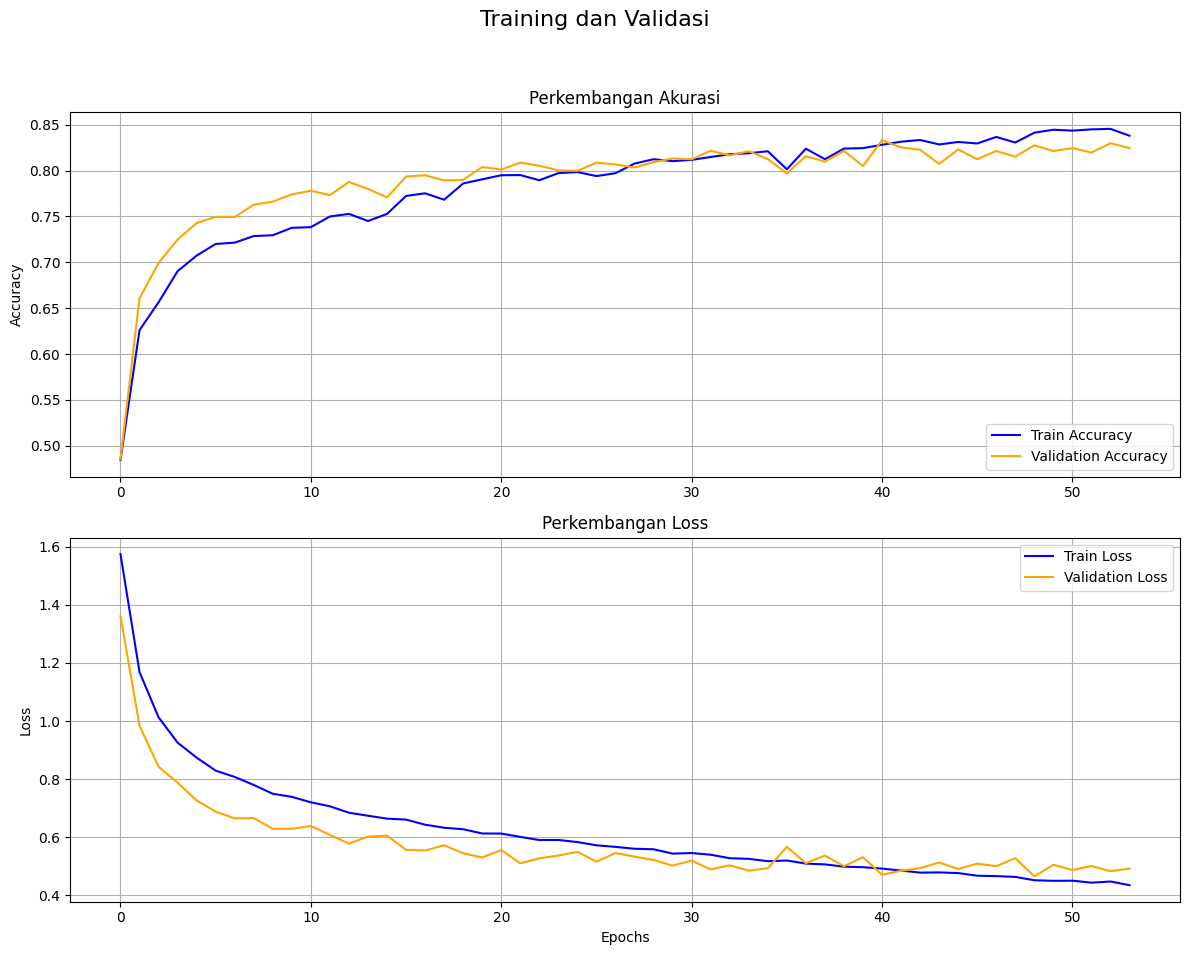

In [17]:
# --- Buat Grafik Garis (Line Chart) ---
print("\n" + "="*60)
print("--- GRAFIK PERKEMBANGAN TRAINING ---")
print("="*60)

# Membuat sebuah figure dengan 2 baris subplot, 1 kolom
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Training dan Validasi', fontsize=16)

# --- Plot untuk Akurasi (di bagian atas, ax1) ---
ax1.plot(history_train_acc, label='Train Accuracy', color='blue')
ax1.plot(history_val_acc, label='Validation Accuracy', color='orange')
ax1.set_ylabel('Accuracy')
ax1.set_title('Perkembangan Akurasi')
ax1.legend(loc='lower right')
ax1.grid(True)

# --- Plot untuk Loss (di bagian bawah, ax2) ---
ax2.plot(history_train_loss, label='Train Loss', color='blue')
ax2.plot(history_val_loss, label='Validation Loss', color='orange')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_title('Perkembangan Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Merapikan layout agar tidak tumpang tindih
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- HASIL EVALUASI PADA TEST SET ---

[HASIL] Akurasi Akhir pada Test Set: 0.8169

[HASIL] Laporan Klasifikasi Lengkap untuk Test Set:
              precision    recall  f1-score   support

       angry       0.82      0.73      0.77       326
     disgust       0.62      0.43      0.51        23
        fear       0.74      0.37      0.50        94
       happy       0.87      0.93      0.90       929
     neutral       0.79      0.90      0.84      1279
         sad       0.74      0.50      0.60       448
    surprise       0.85      0.82      0.83       446

    accuracy                           0.82      3545
   macro avg       0.78      0.67      0.71      3545
weighted avg       0.81      0.82      0.81      3545


[HASIL] Confusion Matrix untuk Test Set:


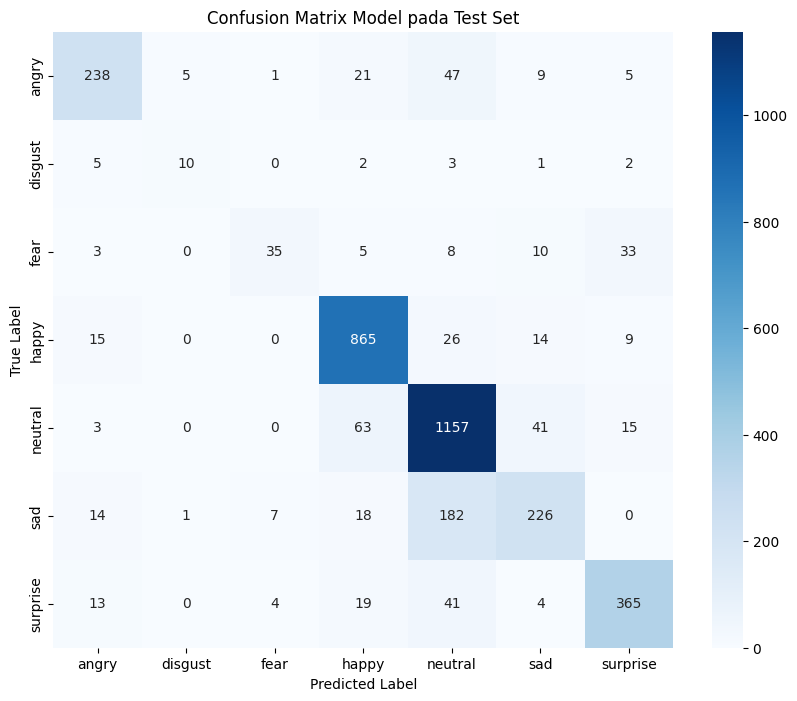

In [18]:
# --- Evaluasi Model pada Test Set ---
print("\n" + "="*60)
print("--- HASIL EVALUASI PADA TEST SET ---")
print("="*60)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        img_batch, label_batch = batch
        img_batch, label_batch = img_batch.to(device), label_batch.type(torch.LongTensor).to(device)
        output = final_model(img_batch)
        _, predicted = torch.max(output.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=classes, zero_division=0)
cm = confusion_matrix(all_labels, all_preds)

print(f"\n[HASIL] Akurasi Akhir pada Test Set: {accuracy:.4f}")
print("\n[HASIL] Laporan Klasifikasi Lengkap untuk Test Set:")
print(report)
print("\n[HASIL] Confusion Matrix untuk Test Set:")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Model pada Test Set')
plt.show()

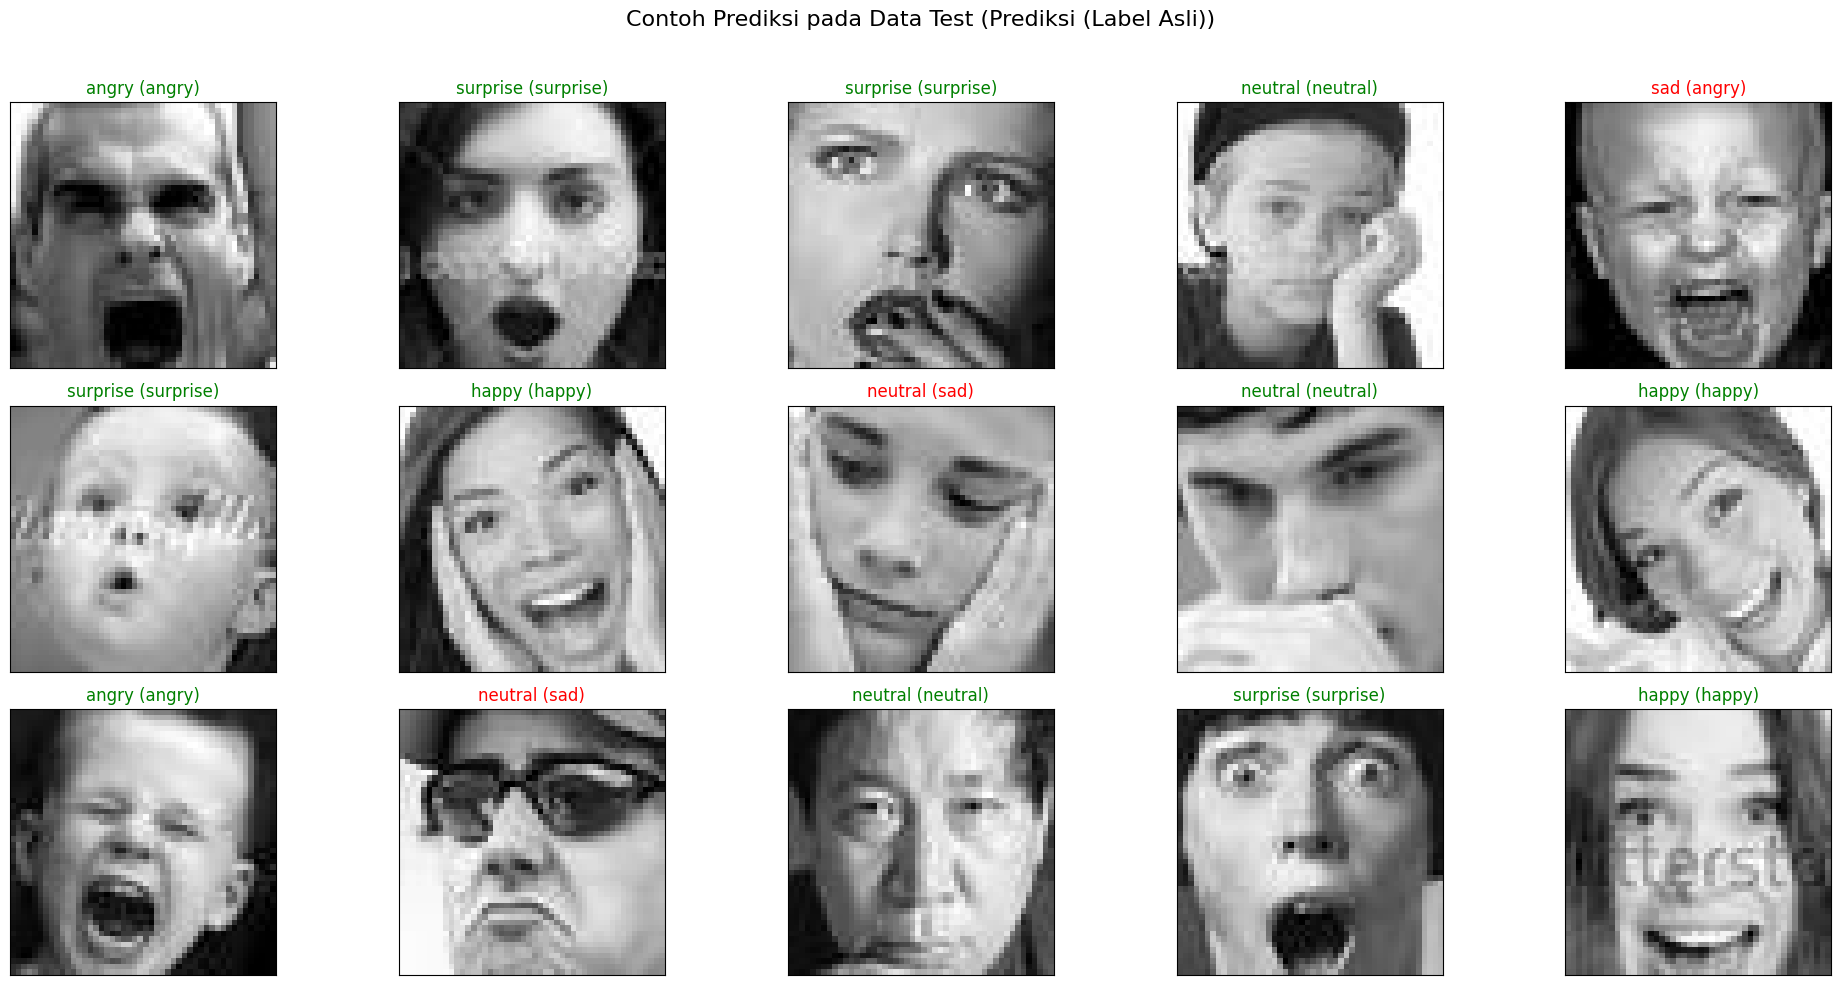

In [23]:
final_model.eval()

preds = []
labels = []

# Simpan juga gambar validasi agar bisa ditampilkan
images_val = []

with torch.no_grad():
    for img_batch, label_batch in test_dataloader:
        img_batch = img_batch.to(device)
        output = final_model(img_batch)  # Gunakan model final

        preds.extend(torch.argmax(output, dim=1).cpu().tolist())
        labels.extend(label_batch.cpu().tolist())
        images_val.extend(img_batch.cpu())  # simpan gambar untuk visualisasi

# Pilih beberapa sample random untuk ditampilkan
num_images_to_show = 15
random_indices = np.random.choice(len(labels), num_images_to_show, replace=False)

f, axarr = plt.subplots(3, 5, figsize=(20, 10))
f.suptitle("Contoh Prediksi pada Data Test (Prediksi (Label Asli))", fontsize=16)

for i in range(3):
    for j in range(5):
        idx_in_plot = i * 5 + j
        idx = random_indices[idx_in_plot]
        
        img = images_val[idx].detach().squeeze()
        
        pred_label = classes[preds[idx]]
        true_label = classes[labels[idx]]
        is_correct = (preds[idx] == labels[idx])
        
        axarr[i, j].imshow(img, cmap='gray')
        axarr[i, j].set_title(f'{pred_label} ({true_label})',
                            color=('green' if is_correct else 'red'),
                            fontsize=12)
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [24]:
# Simpan Model
# Path untuk menyimpan file bobot
PATH = 'model/model_cnn_2.pth'

# Menyimpan state_dict (bobot dan bias) dari model
torch.save(final_model.state_dict(), PATH)

print(f"Bobot model berhasil disimpan di {PATH}")

Bobot model berhasil disimpan di model/model_cnn_2.pth
